# Transporter analysis of bacillus mother-spore

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)


/home/jt/work/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/work/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/sporeme/bacillusme/__init__.py


### NDP and NTP transport

In [2]:
import sympy
import cobrame
import pickle
from cobrame.util.helper_functions import solve_me_model,flux_based_reactions
def gene_ko(model,genes):
    for g in genes:
        model.reactions.get_by_id('translation_{}'.format(g)).bounds = (0,0)
    return model

def load_spore_model(add_transport = False):
    with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as infile:
        model = pickle.load(infile)
    if add_transport:
        model = add_transport_to_model(model,add_transport)
    return model

def load_me_model():
    with open("/home/jt/work/bacillusme-master/bacillusme/me_models/iJT964-ME.pickle", "rb") as infile:
        model = pickle.load(infile)
    return model

def get_response(model,
                 growth_key='mu',
                   max_mu = 0.1,
                   min_mu = .01,
                   using_soplex=False,
                   precision = 1e-6,
                   verbosity=0):
    solve_me_model(model,
                   max_mu = max_mu,
                   min_mu = min_mu,
                   using_soplex=using_soplex,
                   precision = precision,
                   growth_key = growth_key,
                   verbosity=verbosity)
    if model.solution:
        return model.solution.x_dict#['biomass_dilution_s']
    else:
        return {r.id:0. for r in model.reactions}
    
def add_transport_to_model(model,met,cplx = 'PORE-CPLX'):
    rxn = cobrame.MEReaction('{}_FWD_transport'.format(met))
    model.add_reactions([rxn])
    rxn.add_metabolites({
        '{}_c'.format(met):-1,
        '{}_s'.format(met):1
        # cplx:sympy.Symbol('-4.27350427350427e-6*sigma')
    })
    rxn.bounds = (0,1000)
    
    rxn = cobrame.MEReaction('{}_REV_transport'.format(met))
    model.add_reactions([rxn])
    rxn.add_metabolites({
        '{}_c'.format(met):1,
        '{}_s'.format(met):-1
        # cplx+'_s':sympy.Symbol('-4.27350427350427e-6*sigma')
    })
    rxn.bounds = (0,1000)
#     print(rxn.metabolites)
    return model
    
def test_essentiality(genes,add_transport=False):
    d = {}
    # No deg
    print('No deg')
    model = load_spore_model()
    d['no_deg'] = get_response(model,growth_key='sigma')
    print(d['no_deg']['biomass_dilution_s'])
    
    # MC
    print('MC')
    model = load_spore_model(add_transport=add_transport)
    mc_genes = [i for i in genes]
    model = gene_ko(model,mc_genes)
    d['MC'] = get_response(model,growth_key='sigma')
    print(d['MC']['biomass_dilution_s'])
    
    # FS
    print('FS')
    model = load_spore_model(add_transport=add_transport)
    fs_genes = [i+'_s' for i in genes]
    model = gene_ko(model,fs_genes)
    d['FS'] = get_response(model,growth_key='sigma')
    print(d['FS']['biomass_dilution_s'])
    
    # Both
    print('Both')
    model = load_spore_model(add_transport=add_transport)
    both_genes = mc_genes + fs_genes
    model = gene_ko(model,both_genes)
    d['both'] = get_response(model,growth_key='sigma')
    print(d['both']['biomass_dilution_s'])
    
    # Germination
    print('Germination')
    model = load_me_model() 
    model = gene_ko(model,genes)
    d['germination'] = get_response(model,growth_key='mu')
    print(d['germination']['biomass_dilution'])
    return d

In [333]:
sporeme = load_spore_model()

In [327]:
# genes = ["BSU15680"]
# # FS
# print('FS')
# model = load_spore_model()
# model = add_transport_to_model(model,"gdp",cplx = 'PORE-CPLX')
# model = add_transport_to_model(model,"dgdp",cplx = 'PORE-CPLX')
# model = add_transport_to_model(model,"dgmp",cplx = 'PORE-CPLX')
# model = add_transport_to_model(model,"gmp",cplx = 'PORE-CPLX')
# fs_genes = [i+'_s' for i in genes]
# model = gene_ko(model,fs_genes)
# d = get_response(model,growth_key='sigma',max_mu = 2e-3, precision = 1.0)

FS
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
BFFF0000000000000000000000000000
 BFF0000000000000
BFFF0000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    100.0

In [334]:
me = load_me_model()

In [335]:
results = {}

In [ ]:
results['gmk'] = {}
results['gmk']['no_transport'] = test_essentiality(['BSU15680']) # gmk
results['gmk']['gdp_transport'] = test_essentiality(['BSU15680'],add_transport = 'gdp') # gmk
results['gmk']['gtp_transport'] = test_essentiality(['BSU15680'],add_transport = 'gtp') # gmk

No deg
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    1

In [ ]:
results['cmk_pyrG'] = {}
results['cmk_pyrG']['no_transport'] = test_essentiality(['BSU22890','BSU37150']) # cmk + pyrG
results['cmk_pyrG']['cdp_transport'] = test_essentiality(['BSU22890','BSU37150'],add_transport = 'cdp')
results['cmk_pyrG']['ctp_transport'] = test_essentiality(['BSU22890','BSU37150'],add_transport = 'ctp')

In [ ]:
with open("transport_results_high-spoAQ.pickle", "wb") as outfile:
    pickle.dump(results,outfile)

In [ ]:
with open("./transport_results_high-spoAQ.pickle", "rb") as f:
    results = pickle.load(f)

In [347]:
import pandas as pd

In [348]:
flux_dict = results['gmk']['gdp_transport']['FS']
# df = flux_based_reactions(sporeme,'gdp_s',flux_dict=flux_dict)
flux_dict['gdp_FWD_transport'],flux_dict['gdp_REV_transport']

(0.003303821460373403, 0.0)

In [349]:
flux_dict = results['gmk']['gdp_transport']['MC']
# df = flux_based_reactions(sporeme,'gdp_s',flux_dict=flux_dict)
flux_dict['gdp_FWD_transport'],flux_dict['gdp_REV_transport']

(0.0, 0.021647583908296315)

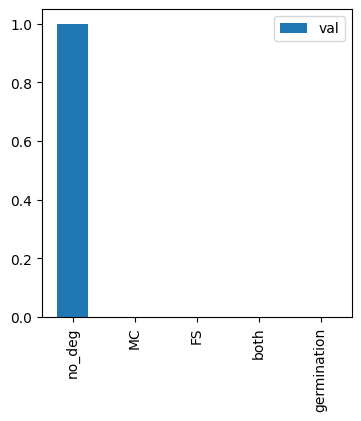

In [350]:
condition = 'no_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

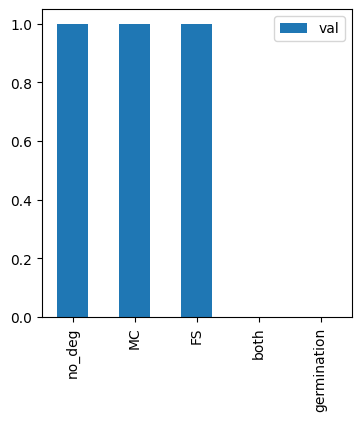

In [351]:
condition = 'gdp_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

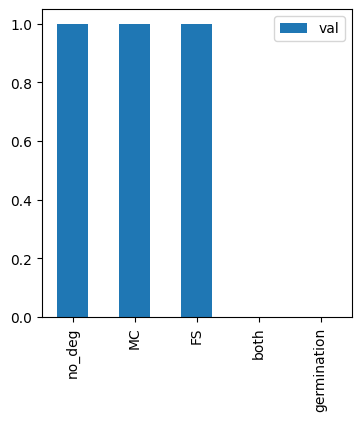

In [352]:
condition = 'gtp_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

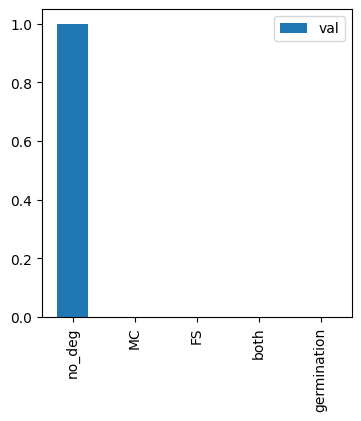

In [353]:
condition = 'no_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

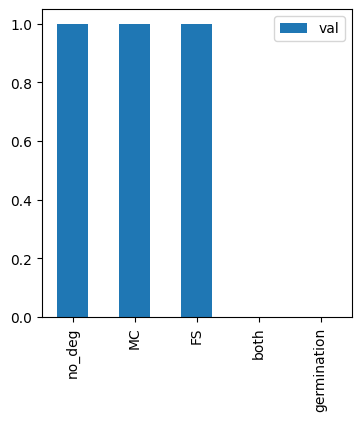

In [354]:
condition = 'cdp_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

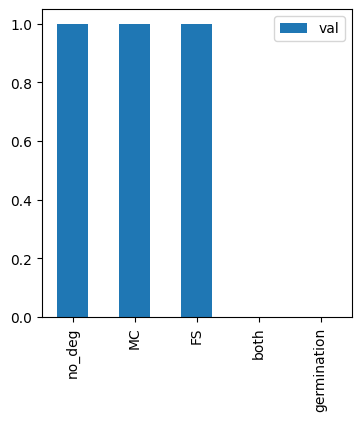

In [355]:
condition = 'ctp_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

### NDK

In [368]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
d = test_essentiality(['BSU15680'])
print(d)

No deg
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    1

In [ ]:
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in d.items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_ndk-spoAQ.svg'.format(gene,condition),format='SVG')

### Is CS essential for growth? (citZ)

In [ ]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
me.reactions.get_by_id('CS_FWD_BSU29140-MONOMER').upper_bound=0

In [ ]:
me.reactions.get_by_id('CS_FWD_BSU09440-MONOMER').upper_bound=0

In [ ]:
solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6)

In [ ]:
flux_dict = me.get_metabolic_flux()
pd.DataFrame.from_dict({'flux':flux_dict})#.to_csv('../fluxdist_CS-.csv')

### Energy mechanisms

In [ ]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
if sporeme.solution: print(sporeme.solution)

In [357]:
df = flux_based_reactions(sporeme,'atp_s',only_types=['MetabolicReaction'])

<AxesSubplot:>

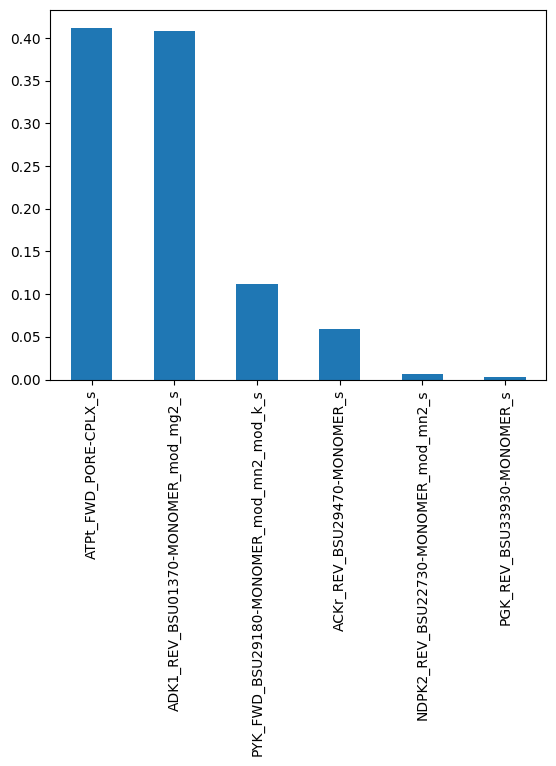

In [358]:
prod_df = df[df['met_flux']>0]['met_flux']
prod_df.div(prod_df.sum()).plot.bar()

### Closing mechanisms

In [359]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [360]:
sporeme.solution.x_dict['biomass_dilution_s']

0.03130950927734375

In [363]:
main_mechanisms = ['ACKr_REV_BSU29470-MONOMER',
                    'PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k']

In [364]:
for r in main_mechanisms:
#     sporeme.reactions.get_by_id(r).bounds = (0,0)
    sporeme.reactions.get_by_id(r+'_s').bounds = (0,0)

In [365]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-3,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 53.288655 seconds
Finished substituting S,lb,ub in 2.106452 seconds
Finished makeME_LP in 0.313435 seconds
Getting MINOS parameters from ME_NLP...
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling mi

In [366]:
sporeme.solution.x_dict["biomass_dilution_s"]

0.03046875

In [367]:
flux_based_reactions(sporeme,'atp_s',only_types=['MetabolicReaction'],growth_symbol = 'sigma')

,lb,ub,rxn_flux,met_flux,reaction
ADK1_REV_BSU01370-MONOMER_mod_mg2_s,0,999999,6.20877,6.20877,2.0 adp_s --> -4.27350427350427e-6*sigma BSU01370-MONOMER_mod_mg2_s + amp_s + atp_s
ATPt_FWD_PORE-CPLX_s,0,1000,6.19571,6.19571,atp_c --> -4.27350427350427e-6*sigma PORE-CPLX_s + atp_s
NDPK1_FWD_BSU22730-MONOMER_mod_mn2_s,0,999999,0.119424,-0.119424,atp_s + gdp_s --> -4.27350427350427e-6*sigma BSU22730-MONOMER_mod_mn2_s + adp_s + gtp_s
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s,0,999999,0.0893571,0.0893571,amp_s + h_s + prpp_s --> -1.38413361031386e-5*sigma BSU00510-MONOMER_mod_mn2_mod_pi_s + atp_s + r5p_s
ACCOAC_FWD_CPLX000-1_s,0,999999,0.0537942,-0.0537942,accoa_s + atp_s + hco3_s --> -4.27350427350427e-6*sigma CPLX000-1_s + adp_s + h_s + malcoa_s + pi_s
...,...,...,...,...,...
ETHSabc_FWD_PORE-CPLX_s,0,999999,0,-0,atp_s + eths_c + h2o_s --> -4.27350427350427e-6*sigma PORE-CPLX_s + adp_s + eths_s + h_s + pi_s
METAT_FWD_BSU30550-MONOMER_s,0,999999,0,-0,atp_s + h2o_s + met__L_s --> -1.16427860227893e-5*sigma BSU30550-MONOMER_s + amet_s + pi_s + ppi_s
ARGKr_REV_CPLX_dummy_s,0,999999,0,0,adp_s + argp_s + h_s --> -4.27350427350427e-6*sigma CPLX_dummy_s + arg__L_s + atp_s
LAAL18_FWD_BSU37710-MONOMER_s,0,999999,0,-0,atp_s + ile__L_s + ser__L_s --> -4.27350427350427e-6*sigma BSU37710-MONOMER_s + adp_s + h_s + pi_s + ser_L_ile__L_s


# Amino acids

In [212]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [12]:
pd.DataFrame.from_dict({'flux':sporeme.solution.x_dict}).to_csv('Supplementary File 2.csv')

In [13]:
# for r in get_transport_reactions(sporeme,'met__L_s',comps=['c','s']):
#     print(r.id)
#     r.bounds = (0,0)
# solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-3,growth_key = 'sigma')

In [14]:
if sporeme.solution: print(sporeme.solution.x_dict['biomass_dilution_s'])

0.03119659423828125


In [15]:
for m in sporeme.metabolites.query(re.compile('^[a-z]{3}__L_s|^gly_s$')):
    df = flux_based_reactions(sporeme,m.id,only_types=['MetabolicReaction'])
    prod = df[df['met_flux']>0]['met_flux']
    prod = prod.div(prod.sum())
    top = df.sort_values('met_flux').iloc[[-1]]
    print(m)
    if top['met_flux'][0] > 0:
        print(top['reaction'][0])
        print(top['met_flux'][0])
        print('{} %'.format(str(prod.loc[top.index[0]]*100)))
    else:
        print('No production')
    print('\n')

met__L_s
atp_s + h2o_s + met__L_c --> -4.27350427350427e-6*sigma PORE-CPLX_s + adp_s + h_s + met__L_s + pi_s
0.0006543461050009536
100.0 %


trp__L_s
h_c + trp__L_c --> -4.27350427350427e-6*sigma PORE-CPLX_s + h_s + trp__L_s
0.00023385171556617476
100.0 %


glu__L_s
akg_s + leu__L_s --> 4mop_s + -4.27350427350427e-6*sigma BSU38550-MONOMER_s + glu__L_s
0.016574467350134223
100.0 %


ser__L_s
h_c + ser__L_c --> -4.27350427350427e-6*sigma PORE-CPLX_s + h_s + ser__L_s
0.005448185299332983
100.0 %


lys__L_s
h_s + lys__L_c --> -4.27350427350427e-6*sigma PORE-CPLX_s + h_c + lys__L_s
0.0029189098663242427
100.0 %


phe__L_s
glu__L_s + phpyr_s --> -4.27350427350427e-6*sigma BSU34890-MONOMER_s + akg_s + phe__L_s
0.0009275286255409628
100.0 %


gly_s
gly_c + h_c --> -4.27350427350427e-6*sigma PORE-CPLX_s + gly_s + h_s
0.0018013979373187787
93.84172486610518 %


leu__L_s
4mop_s + h_s + nadh_s + nh4_s --> -4.27350427350427e-6*sigma BSU24080-MONOMER_s + h2o_s + leu__L_s + nad_s
0.01857411070500078


In [40]:
flux_based_reactions(sporeme,"cyst__L_s",only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p_s,0,999999,0.000182371,-0.000182371,cyst__L_s + h2o_s --> 2obut_s + -4.27350427350427e-6*sigma BSU27250-MONOMER_mod_pydx5p_s + cys__L_s + nh4_s
CYSTabc_FWD_PORE-CPLX_s,0,999999,0.000182371,0.000182371,atp_s + cyst__L_c + h2o_s --> -4.27350427350427e-6*sigma PORE-CPLX_s + adp_s + cyst__L_s + h_s + pi_s
CYSTL_FWD_BSU11880-MONOMER_s,0,999999,0,-0,cyst__L_s + h2o_s --> -1.19594497122028e-5*sigma BSU11880-MONOMER_s + hcys__L_s + nh4_s + pyr_s
SHSL1_FWD_BSU11870-MONOMER_s,0,999999,0,0,cys__L_s + suchms_s --> -4.27350427350427e-6*sigma BSU11870-MONOMER_s + cyst__L_s + h_s + succ_s
CYSTS_FWD_BSU27260-MONOMER_s,0,999999,0,0,hcys__L_s + ser__L_s --> -1.44500166278251e-5*sigma BSU27260-MONOMER_s + cyst__L_s + h2o_s


# Nucleotides

In [ ]:
for m in sporeme.metabolites.query(re.compile('^[guca][m]p_s$')):
    df = flux_based_reactions(sporeme,m.id,only_types=['MetabolicReaction'])
    prod = df[df['met_flux']>0]['met_flux']
    prod = prod.div(prod.sum())
    top = df.sort_values('met_flux').iloc[[-1]]
    print(m)
    if top['met_flux'][0] > 0:
        print(top['reaction'][0])
        print(top['met_flux'][0])
        print('{} %'.format(str(prod.loc[top.index[0]]*100)))
    else:
        print('No production')
    print('\n')

In [ ]:
for r in sporeme.metabolites.get_by_id('BSU37150-MONOMER_mod_mg2').reactions:
    print(r.id)
    print(r.reaction)

In [ ]:
flux_based_reactions(sporeme,'ctp_s',only_types=['MetabolicReaction'])

# STRP comparison

In [43]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [44]:
plt.rcParams['svg.fonttype'] = 'none'

In [45]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [46]:
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [47]:
l = ['scoB','argJ','citZ','pckA','ilvB','metE','lutC','argD','argB','pyrK','pdhD','gmk','cmk','eno','pyk','gapA']

In [48]:
set(l) & set(confirmed_depletions)

{'argJ', 'citZ', 'ilvB', 'lutC', 'pckA'}

In [49]:
d = {}
for g in l:
    locus = name_to_locus[g]
    if not sporeme.metabolites.query(locus):
        print(g, ' not in model')
        continue
    mc = sporeme.solution.x_dict['translation_{}'.format(locus)]
    fs = sporeme.solution.x_dict['translation_{}_s'.format(locus)]
    d[g] = {'mc':mc,'fs':fs}

lutC  not in model


In [50]:
df = pd.DataFrame.from_dict(d).T
df[df<1e-16] = 0
df = df.div(df.sum(axis=1),axis=0).fillna(0) * 100

Text(0, 0.5, 'Expression fraction')

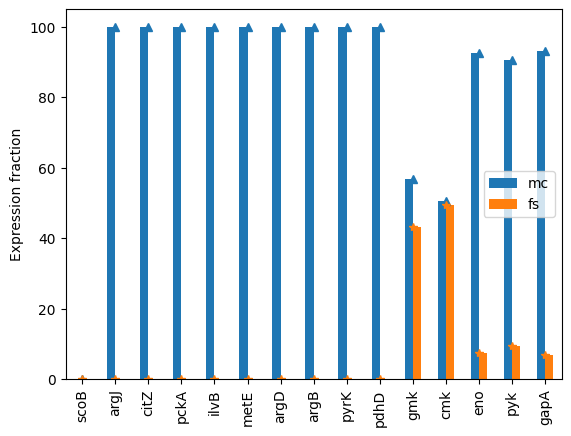

In [51]:
ax = df.plot.bar(stacked=False)
# ax.invert_yaxis()
plt.plot(df.index,df['mc'],'^')
plt.plot(df.index,df['fs'],'*')
plt.ylabel('Expression fraction')
# plt.savefig('figures/STRP_comparison.svg',format='SVG')

### FVA

In [230]:
from qminospy.me2 import ME_NLP
sporeme.mu = "sigma"
obj_val = sporeme.solution.f
nlp = ME_NLP(sporeme, growth_key="sigma", growth_rxn="biomass_dilution_s")

In [219]:
mcrxns = ["translation_" + name_to_locus[g] for g in l]
fsrxns = ["translation_" + name_to_locus[g] + "_s" for g in l]
res = nlp.varyme(mu_fixed=0.99*obj_val, rxns_fva0 = [r for r in mcrxns + fsrxns if r in sporeme.reactions])
pd.DataFrame.from_dict(res[0]).T

Stacking J took 0.006555 seconds
Making I & V took 0.222948 seconds
Making P took 0.010704 seconds
Stacking bl & bu took 0.000462 seconds
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated hs, pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expa

,maximum,minimum
translation_BSU38980,5.539330e-24,5.539331e-24
translation_BSU11200,-6.161273e-39,-6.161273e-39
translation_BSU29140,4.588093e-32,4.588093e-32
translation_BSU30560,0.000000e+00,0.000000e+00
translation_BSU28310,0.000000e+00,0.000000e+00
translation_BSU13180,0.000000e+00,0.000000e+00
translation_BSU11220,0.000000e+00,0.000000e+00
translation_BSU11210,0.000000e+00,0.000000e+00
translation_BSU15530,1.033697e-32,1.033697e-32
translation_BSU14610,1.160304e-57,1.160304e-57


  -1.99341455760077914853382902348069207E-0025
3FACED8BA8742686D76A2111FB6FC380
 3ACED8BA8742686D
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS finished.
 inform =           1
 ninf   =         147
 sinf   =   1.00396752397805629043758733980831950E-0005
 obj    =   0.00000000000000000000000000000000000      
                               0
                0
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS finished.
 inform =           1
 ninf   =         147
 sinf   =   1.00396752397805629053040028259974229E-0005
 obj    =   0.00000000000000000000000000000000000      
                               0
                0
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS finished.
 inform =           1
 ninf   =         147
 sinf   =   1.00396752397805490593924483280563740E-0005
 obj    =   0.00000000000000000000000000000000000      
                               0
                0
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS fin

In [220]:
d = {}
for g in l:
    locus = name_to_locus[g]
    if not sporeme.metabolites.query(locus):
        print(g, ' not in model')
        continue
    mc = res[0]['translation_{}'.format(locus)]
    fs = res[0]['translation_{}_s'.format(locus)]
    d[g] = {'mc':mc,'fs':fs}
d

lutC  not in model


{'scoB': {'mc': {'maximum': 5.5393302071061074e-24,
   'minimum': 5.53933079008459e-24},
  'fs': {'maximum': 2.1468183592762418e-27,
   'minimum': 2.1468183592762418e-27}},
 'argJ': {'mc': {'maximum': -6.161273209126979e-39,
   'minimum': -6.161273209126979e-39},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'citZ': {'mc': {'maximum': 4.5880930465024147e-32,
   'minimum': 4.5880930465024147e-32},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'pckA': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'ilvB': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'metE': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'argD': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'argB': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 9.880657164506688e-31, 'minimum': 9.880657164506688e-31}},
 'pyrK': {'mc': {'maximum': 1.0336969826846225e-32,
   'mi

# With NTP transport

In [ ]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
def add_transport(model,mets):
    for i in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(i))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(i):-1,
            '{}_s'.format(i):1
        })
        rxn.bounds = (-1000,1000)

In [ ]:
add_transport(sporeme,['gtp','ctp','utp'])

In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-3,growth_key = 'sigma')

In [ ]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [ ]:
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [ ]:
l = ['scoB','argJ','citZ','pckA','ilvB','metE','lutC','argD','argB','pyrK','pdhD','gmk','cmk','eno','pyk','gapA']

In [ ]:
set(l) & set(confirmed_depletions)

In [ ]:
d = {}
for g in l:
    locus = name_to_locus[g]
    if not sporeme.metabolites.query(locus):
        print(g, ' not in model')
        continue
    mc = sporeme.solution.x_dict['translation_{}'.format(locus)]
    fs = sporeme.solution.x_dict['translation_{}_s'.format(locus)]
    d[g] = {'mc':mc,'fs':fs}

In [ ]:
df = pd.DataFrame.from_dict(d).T
df = df.div(df.sum(axis=1),axis=0).fillna(0)

In [ ]:
# df.plot.bar()
# plt.plot(df.index,df['mc'],'^')
# plt.plot(df.index,df['fs'],'*')
# plt.ylabel('Normalized expression')
# plt.savefig('figures/STRP_comparison.svg',format='SVG')

# Characterizing transport

In [ ]:
version = 'v4_proteomics'

In [ ]:
with open("./sporeme_solution_{}.pickle".format(version), "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [ ]:
# Get transport reactions

def get_compartments(r):
    comps = []
    if isinstance(r,cobrame.MetabolicReaction):
        for m in r.metabolites:
            if isinstance(m,cobrame.Metabolite):
                comps.append(m.id[-1])
    return list(set(comps))

def get_all_transport(model):
    transport_reactions = []
    for r in tqdm(model.reactions):
        comps = get_compartments(r)
        if len(comps) > 1 and 's' in comps:
            transport_reactions.append(r.id)
    return list(set(transport_reactions))

def get_active_transport(transport_reactions):
    active_transporters = []
    for r in tqdm(transport_reactions):
        if 'SPONT' not in r and abs(sporeme.solution.x_dict[r])>0.:
            active_transporters.append(r)
    # Include arginine transport
    arginine_transport = [r.id for r in get_transport_reactions(sporeme,'arg__L_c',comps=['c','s'])+get_transport_reactions(sporeme,'arg__L_c',comps=['s','c'])]
    [active_transporters.append(r) for r in arginine_transport]
    active_transporters = list(set(active_transporters))
    return active_transporters

## Check by group of transporters of metabolite

In [ ]:
def get_necessary_metabolites(model,active_transporters):
    necessary_metabolites = []
    for r in tqdm(active_transporters):
        rxn = model.reactions.get_by_id(r)
        for m in rxn.products:
            if not isinstance(m,cobrame.Metabolite):
                continue
            met_root = m.id[:-2]
            for i in rxn.reactants:
                if met_root in i.id:
                    necessary_metabolites.append(m.id)
    return list(set(necessary_metabolites))

def get_all_available_transport(model,necessary_metabolites):
    available_transport = []
    at_dict = {}
    for m in tqdm(necessary_metabolites):
        rxns = get_transport_reactions(model,m,comps=['c','s']) + get_transport_reactions(model,m,comps=['s','c'])
        [available_transport.append(r.id) for r in rxns]
        at_dict[m] = []
        [at_dict[m].append(r.id) for r in rxns]
    return list(set(available_transport)), at_dict

In [ ]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [ ]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

In [ ]:
active_transporters = get_active_transport(transport_reactions)
necessary_metabolites = get_necessary_metabolites(sporeme,active_transporters)
necessary_metabolites.remove('h_s')
necessary_metabolites.remove('h_c')
available_transport, at_dict = get_all_available_transport(sporeme,necessary_metabolites)

In [ ]:
print('{} active transport reactions identified'.format(len(active_transporters)))
print('{} necessary metabolites identified'.format(len(necessary_metabolites)))
print('{} available transport reactions identified'.format(len(available_transport)))

In [ ]:
all_transporters_to_open = list(set(active_transporters + available_transport))
print('{} open transport reactions identified'.format(len(all_transporters_to_open)))
print('Included {}'.format(set(active_transporters)-set(available_transport)))

In [ ]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,necessary_metabolites, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')

In [ ]:
flux_results_df.to_csv('group_KO_flux_results_{}.csv'.format(version))

In [ ]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))
plt.tight_layout()
plt.savefig("./figures/group_KO_flux_results_{}.svg".format(version), format="SVG")

### Close metabolite one by one
Including information about arginine being transported

In [ ]:
with open("./sporeme_solution_{}.pickle".format(version), "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False).drop('base').index.to_list()

In [ ]:
sorted_mets.remove('arg__L_s')
sorted_mets.append('arg__L_s')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,sorted_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout',sequential=True)
flux_results_df.to_csv('group_1by1_KO_flux_results_{}.csv'.format(version))

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("./figures/group_1by1_KO_flux_results_{}.svg".format(version), format="SVG")

# Cases

In [ ]:
pd.set_option('display.max_colwidth', None)

### Original

In [ ]:
# CYTK2 KO
version = 'v4'

In [ ]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True)
last_met = sorted_mets.index[list(sorted_mets.index).index(sorted_mets[sorted_mets<1e-5].index[-1])+1]
print(last_met)
flux_dict = flux_results_df[last_met].to_dict() # Last time before model breaks

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets.index[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()

In [ ]:
flux_dict['biomass_dilution']

In [ ]:
met='atp_s' # ATP production and glucose uptake
prod_atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
prod_atp_df = prod_atp_df[prod_atp_df['met_flux']>0]
prod_atp_df['met_flux'].sum()

In [ ]:
prod_atp_df['met_flux'].div(prod_atp_df['met_flux'].sum())

### All mechanisms KO

In [ ]:
version = 'v5_all_KO'
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True)
last_met = sorted_mets.index[list(sorted_mets.index).index(sorted_mets[sorted_mets<1e-5].index[-1])+1]
print(last_met)
flux_dict = flux_results_df[last_met].to_dict() # Last time before model breaks

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets.index[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()

In [ ]:
flux_dict['biomass_dilution']

In [ ]:
met='atp_s' # ATP production and glucose uptake
prod_atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
prod_atp_df = prod_atp_df[prod_atp_df['met_flux']>0]
prod_atp_df['met_flux'].sum()

In [ ]:
prod_atp_df['met_flux'].div(prod_atp_df['met_flux'].sum())

In [ ]:
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
flux_based_reactions(sporeme,'prpp_s',flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
sporeme.metabolites.prpp_s.name